# Austin Crime Project 

___

By: Alejandro Garcia, Matthew Luna, Kristofer Rivera, Oliver Ton
<br>
Date: June 2022

___

## Project Goals



___

## Project Description



___

## Importing the Required Modules

Everything we need to run the code blocks in this notebook are located in the top level directory. To run the code blocks in this report you will need numpy, pandas, matplotlib, seaborn, and sklearn installed on your computer.

___

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from acquire import *
from prepare import *
from explore import *
from wrangle import *

#Settting matplotlib/seaborn defaults
plt.rc('figure', figsize=(16, 8))
plt.style.use('seaborn-darkgrid')

## Data Acquisition

The data set was gathered from publicly available data provided by the Austin Police Department on data.austintexas.gov. We created a function to automate gathering the data from the provided API and cache it locally as a CSV file. Our initial data set included 500,000 rows and 31 columns. For ease of use and relevancy, we decided to limit our data to crimes reported between the years 2018 and 2021. After removing data outside this time frame, we were left with 401,955 rows. 

## Data Preparation

After investigating columns with missing values, we decided to drop 15 columns entirely that we deemed to be unuseful or redundant. Next, we made decisions on how to handle the missing values in our remaining 16 columns. For 7 columns, including clearance_status, clearance_date, zip_code, sector, district, latitude, and longitude, we decided that we could not reasonably impute nulls with a value and dropped all missing rows. We had 753 missing values for location_type values which we decided to add to the Other / Unknown value. We had 1438 missing values for council_district which we decided to impute as the most common district. Next, we renamed four columns for readability. We then renamed the values in the clearance_status column with more descriptive values for clarity. Last, we ensured that our columns were using the appropriate data type. We changed latitude and longitude to float values and converted all of the date and time columns to a DateTime data type. After conducting all steps, we were left with 349,581 rows and 17 columns. 

In [2]:
df = wrangle_crime_data()
df.info()

Using cached csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 349581 entries, 34573 to 436548
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   crime_type        349581 non-null  object         
 1   family_violence   349581 non-null  object         
 2   occurrence_time   349581 non-null  datetime64[ns] 
 3   occurrence_date   349581 non-null  datetime64[ns] 
 4   report_time       349581 non-null  datetime64[ns] 
 5   report_date       349581 non-null  datetime64[ns] 
 6   location_type     349581 non-null  object         
 7   address           349581 non-null  object         
 8   zip_code          349581 non-null  float64        
 9   council_district  349581 non-null  float64        
 10  sector            349581 non-null  object         
 11  district          349581 non-null  object         
 12  latitude          349581 non-null  float64        
 13  longitude         34958

## Univariate Analysis

We plotted the distributions of all of our features to help guide our exploration. Most variables had normal or uniform distributions.
The most important takeaway from this analysis was that there is an imbalance in our target variable of clearance_status. We decided to make a new column to use as our target variable called cleared. This column combines 'cleared by arrest' and 'cleared by exception', creating a boolean value for whether or not a case is cleared. For the sake of maintaining data integrity, we decided to leave our imbalanced target variable as is and use either recall or precision as our performance metric in modeling. In a second iteration, we will try downsampling the data to create a more balanced target variable and see if that leads to any modeling performance improvements.

**Below is a histogram of our initial target variable.**

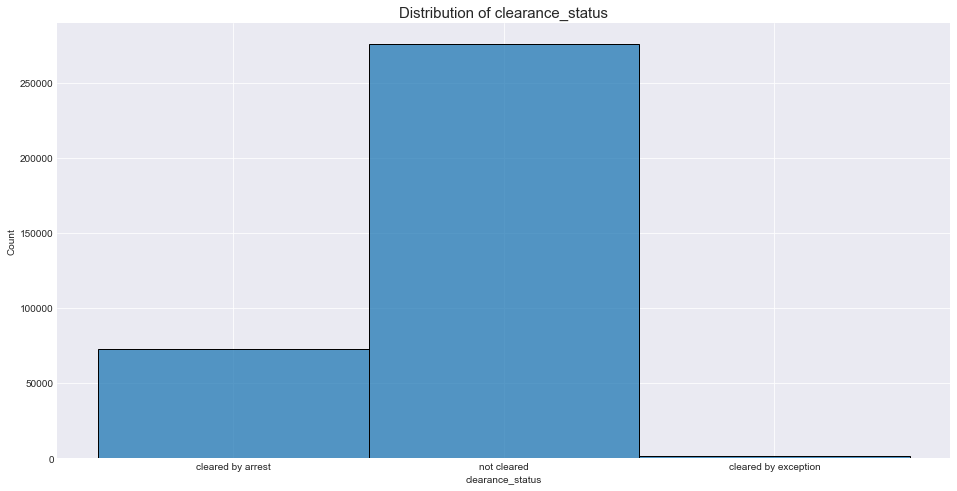

In [3]:
plot_distribution(df, 'clearance_status')

**Below is the distribution of the new target variable after combining cleared by arrest and cleared by exception into one value.**

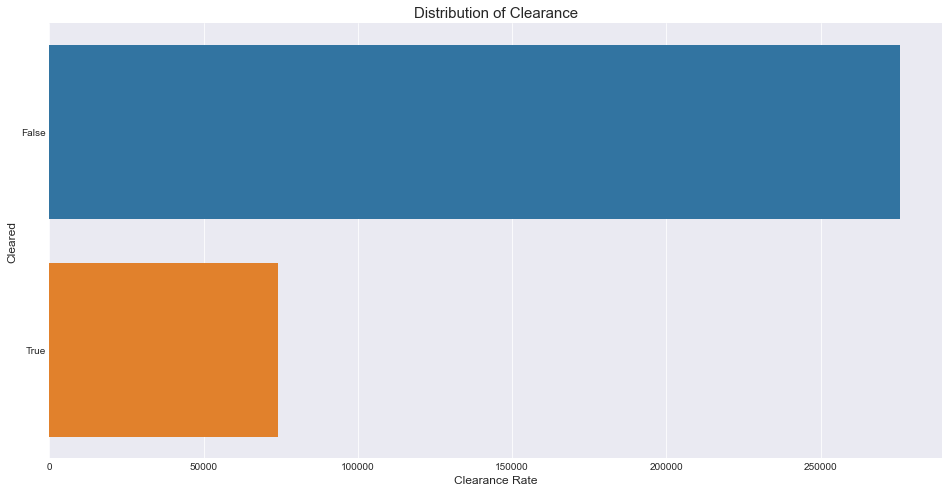

In [4]:
plot_cleared(df)

## Splitting the Data

We split the data into a train, validate, and test sets to be used for exploration, modeling and evaluation. 

Our train set includes 50%, validate includes 30%, and test includes 20% of the data.

In [5]:
train, validate, test = split_data(df)
train.shape, validate.shape, test.shape

((195764, 18), (83900, 18), (69917, 18))

## Exploratory Analysis

In the visualizations below we aim to answer some questions about the data. Details about how these visualization are created can be found in the explore.py file.

### Question 1: Which types of crime are not getting solved/closed?

$H0$: Type of crime and clearance are independent of eachother. 

$Ha$: Type of crime and and clearance are dependent on eachother.

#### Statistical Testing

*Setting confidence level at 95% which makes the alpha = .05*

In [6]:
target = train.cleared
chi2(train.crime_type, target)

The chi2 value between the two variables is 102967.85678373862 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


**A Chi^2 establishes that there is a statistically signifiant dependency.**

#### Visualizations

In [7]:
# Creating a subset of the data that only includes the top 10 crime types
top_crimes_df = subset_top_crimes(train)

*For the sake of visualization we created a subset of the train data frame that only includes the top 10 crimes.*

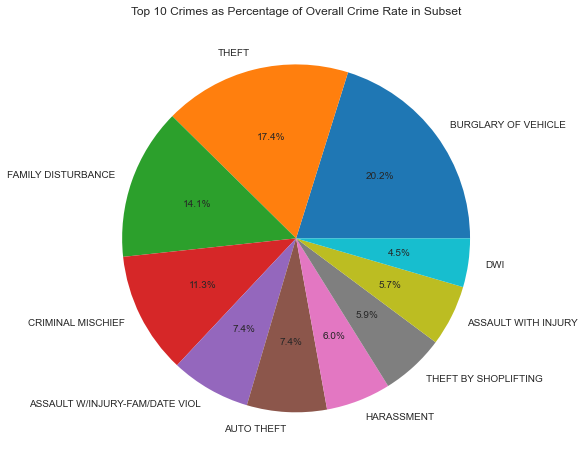

In [8]:
viz1(top_crimes_df)

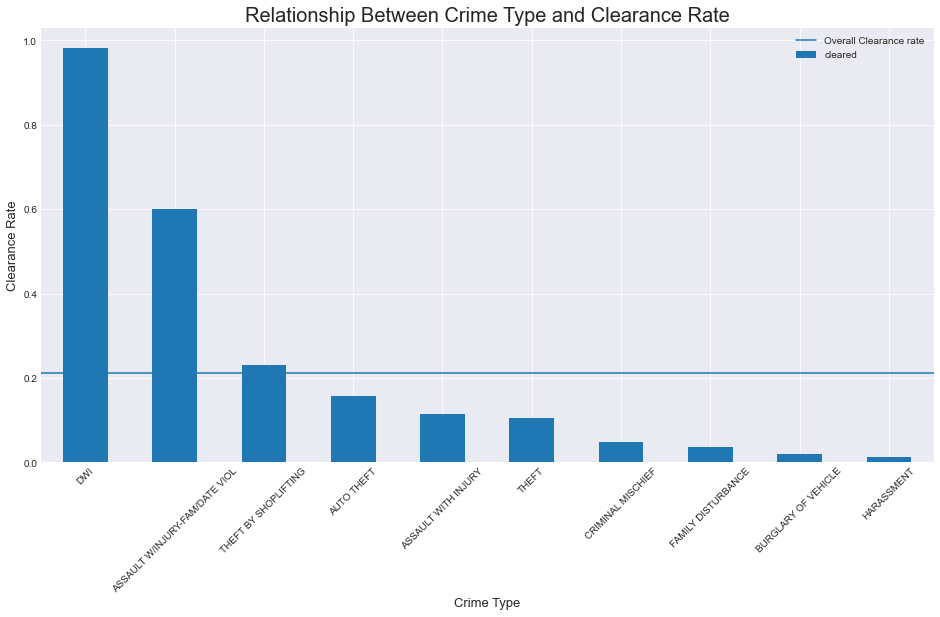

In [9]:
viz2(top_crimes_df, train)

#### Takeaways:

The overall case clearance rate is about 21%, but we have two crime types with clearance rates significantly above that, DWIs at 98% and Domestic Assault (assault bodily injury against a family member) at ~60%. While DWIs, are the least frequent type of crime reported amongst the top 10, they are the most likely crimes to be cleared. The three most frequent crime types (Burglary of Vehicle, Theft, and Family Disturbance) have some of the lowest case clearance rates. This imbalance of crime frequency and clearance rate likely accounts for the low overall clearance rate. Focusing resources towards improving clearance of these crimes would significantly improve overall case clearance.

### Question 2 - Are there certain city council districts with disproportionate levels of crime?

$H0$: Type of crime and clearance are independent of eachother. 

$Ha$: Type of crime and and clearance are dependent on eachother.

#### Statistical Testing



#### Visualizations

#### Takeaways:

*Insert takeways here.*

### Question 3 - Is crime seasonal? Are there times of the year when a crime is more prevalent? 

#### Statistical Testing

$H_0$: There is no difference in crime levels between Fridays and other days of the week.
<br>
$H_a$: There is difference in crime levels between Fridays and other days of the week.

*For the sake of statistical testing and visualization, we created a seperate data frame that has been prepared for time-series analysis and subsets to compare crime levels between Friday and other days of the week.*

In [10]:
# Creating a seperate dataframe prepared for time-series analysis
time_series_df = time_series_df(train)
# Create subsets that include all days but Friday or only Friday for conducting a 1-sample t-test
subset_friday, subset_not_friday = friday_subsets(time_series_df)

t_test_ind(subset_not_friday.cleared, subset_friday.cleared)

The t value between the two samples is 0.6367 and the P-Value is 0.5243498607925576.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.


**An Independent t-test failed to reject the null hypothesis. We are not able to establish a statistically significant difference in crime rates between Fridays and other days of the week.**

#### Visualizations

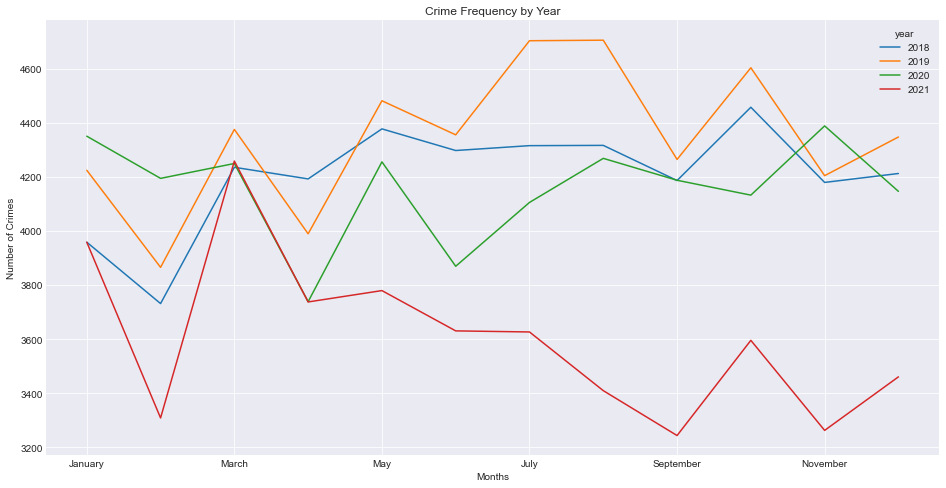

In [11]:
viz5(time_series_df)

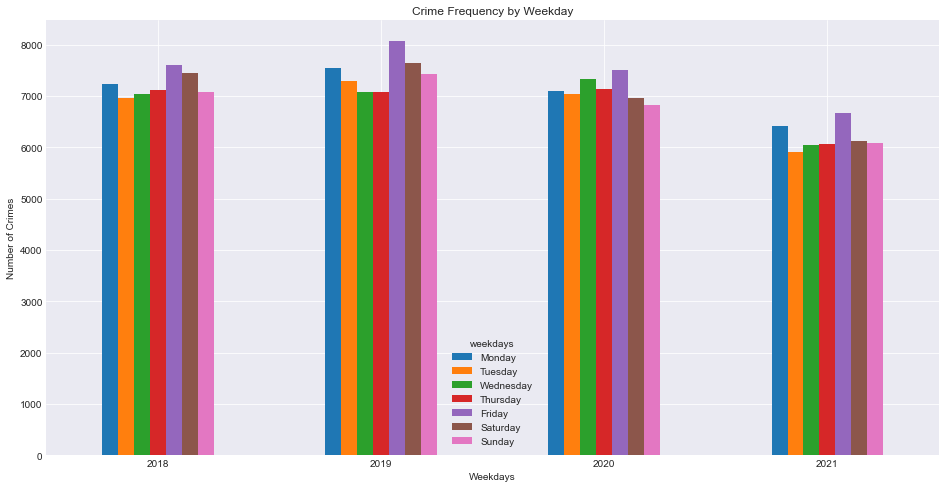

In [12]:
viz6(time_series_df)

#### Takeaways:

Our exploratory analysis shows a steady downward trend in crime since 2018. We see a significant spike in crime in March and in October which align with two large yearly events, South by Southwest and Austin City Limits. As would be expected, we see an exception to these spikes in 2020 when in-person events were cancelled due to the Covid-19 Pandemic. We generally see higher crime rates in the summer months compared to the winter months. On a weekly basis, we see consistently higher crime rates on Fridays though statistical testing was not able to confirm a statistically significant difference.


### Question 4 - Does the difference between time of incident and report time relate to a crime being solved/cleared?

$H0$: Crime seasonality

$Ha$: Crime seasonality

#### Statistical Testing

*Insert hypotheses here.*





### Key Takeaways

___

## Modeling



___

## Key Takeaways and Recommendations



___

## Next Steps